In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
import os
import pandas as pd
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci_Reina/results'
else:
    resPath = '/results'

In [2]:
# simulate and get the stationary state distributions
def sim_get_ss():
    global qs, noiseType, noise, N, maxTime, Nrea, ic, ci_kwargs
    qchain = ','.join([str(q) for q in qs])
    ci_kwargs_chain = ','.join([str(cikw) for cikw in ci_kwargs])
    simCall = f'python Reina_model_gill.py -qs {qchain} -noiseType {noiseType} -noise {noise} -ci_kwargs {ci_kwargs_chain} '
    simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --ss_data'
    call(simCall, shell=True)


In [3]:
qs = [1.0, 1.05]
noiseType, noise = 1, 0.25
N, maxTime, Nrea, ic = 1000, 90.0, 100, 'N'

# testing the normal sigmoidal function, sig1
# ci_kwargs_list = [[0,], [1, 0.35, 40.0], [1, 0.35, 100.0]]
# ci_kwargs_list = [[0,], [1, 0.35, 100.0], ]

# testing the truncated sigmoidal function sig1:
# ci_kwargs_list = [[0,], [1, 0.35, 40, 1], [1, 0.35, 100, 1], [1, 0.5, 40, 1], [1, 0.5, 100, 1]]

# testing the new sig+lin function, sig2:
ci_kwargs_list = [[0,], [2, 0.3, 10.0], [2, 0.3, 500.0], [2, 0.5, 10.0], [2, 0.5, 500.0]]

for ci_kwargs in ci_kwargs_list:
    sim_get_ss()

0.05 0.9500000000000003
0.3199999999999999 0.6800000000000009
0.6619799999999998 0.33802000000000054


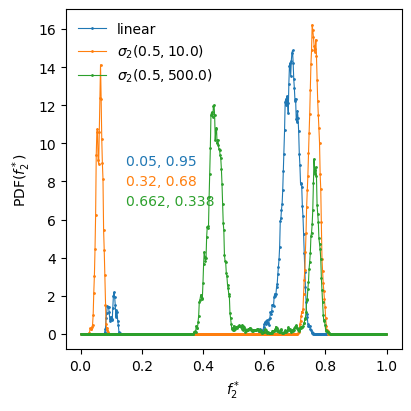

In [8]:
onePlot = True
if onePlot:
    fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
else:
    fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
qchain = '_'.join([str(q) for q in qs])

# ci_kwargs_list = [[1, 0.35, 40.0], ]
# ci_kwargs_list = [[0,], [1, 0.35, 40.0], [1, 0.35, 100.0]]
# ci_kwargs_list = [[0,], [1, 0.5, 40.0], [1, 0.5, 100.0]]

# ci_kwargs_list = [[0,], [1, 0.35, 40.0, 1.0], [1, 0.35, 100.0, 1.0]]

ci_kwargs_list = [[0,], [2, 0.3, 10.0], [2, 0.3, 500.0]]
ci_kwargs_list = [[0,], [2, 0.5, 10.0], [2, 0.5, 500.0]]

# BUILD LABELS FROM CI KWARGS
species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssData_fname = f'sim_qs_{qchain}_noiseType_{noiseType}_noise_{noise}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
    file = resPath + '/' + ssData_fname
    df = pd.read_csv(file)
    hist, bin_edges = np.histogram(df['f2'], bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    if onePlot:
        ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    else:
        ax[0].plot(bin_centers, hist, marker='o', lw=0.8, label=cilabel)
        ax[1].plot(bin_centers, hist, marker='o', lw=0.8)
    binWidth = bin_edges[1]-bin_edges[0]
    prob1 = sum(hist[bin_centers<0.5]*binWidth)
    prob2 = sum(hist[bin_centers>=0.5]*binWidth)
    print(prob1, prob2)
    if onePlot:
        fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())

if onePlot:
    ax.legend(frameon=False)
    ax.set(xlabel='$f_2^*$', ylabel='PDF($f_2^*$)')
else:
    ax[0].set_xlim(0.0, 0.1)
    ax[1].set_xlim(0.7, 0.9)
    ax[0].legend(frameon=False)
    ax[0].set(xlabel='$f_2^*$', ylabel='PDF($f_2^*$)')
    ax[1].set(xlabel='$f_2^*$', ylabel='PDF($f_2^*$)')


qchain = '_'.join([str(q) for q in qs])
# cilabel=f'lin_vs_sig1_cha_x0_{ci_kwargs_list[1][1]}'
# cilabel=f'lin_vs_sig1lin_cha_x0_{ci_kwargs_list[1][1]}'
cilabel=f'lin_vs_sig2_cha_x0_{ci_kwargs_list[1][1]}'
fig.savefig(f'f2_SSdistr_qs_{qchain}_noiseType_{noiseType}_noise_{noise}_N_{N}_{cilabel}.png')